In [1]:
#Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# import model and fit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

#import test and cross val
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

In [2]:
#Read In Data

df = pd.read_csv('finalairbnbdata7_18.csv')

df_eda = pd.read_csv('finalairbnbdata7_18.csv')

df.head()

,id,link,neighborhood,price,listing_type,num_guests,num_bed,num_bath,shared_bath,num_ammenities,number_review,overall_review,accuracy,communication,cleanliness,value,check_in,location
0,25841637,https://www.airbnb.com/rooms/25841637?location...,downtown,158,Private,4,1,1.0,sharedbath,5,86,4.5,4.7,4.7,4.8,4.8,4.8,4.6
1,24392338,https://www.airbnb.com/rooms/24392338?location...,downtown,225,Entire,4,2,1.0,notshared,4,109,4.5,4.8,4.9,4.7,4.8,4.8,4.9
2,25838923,https://www.airbnb.com/rooms/25838923?location...,downtown,130,Private,2,1,1.0,sharedbath,5,73,4.5,4.7,4.7,4.9,4.9,4.9,4.6
3,13971471,https://www.airbnb.com/rooms/13971471?location...,downtown,79,Shared,1,1,1.0,sharedbath,5,230,5.0,4.9,5.0,4.9,4.9,4.9,5.0
4,34929016,https://www.airbnb.com/rooms/34929016?location...,downtown,86,Private,1,1,1.0,sharedbath,4,10,5.0,4.8,5.0,4.4,4.9,4.9,5.0


In [3]:
df.describe()

,id,price,num_guests,num_bed,num_bath,num_ammenities,number_review,overall_review,accuracy,communication,cleanliness,value,check_in,location
count,1.056000e+03,1056.000000,1056.000000,1056.000000,1056.000000,1056.00000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000
mean,2.387619e+07,309.304924,2.910038,1.225379,1.116004,4.28125,51.232008,3.540720,3.575663,3.651515,3.509848,3.643277,3.643277,3.653125
std,1.148859e+07,379.300956,1.885453,0.653362,0.432166,0.62603,73.805702,2.018222,2.028869,2.066776,1.996731,2.061466,2.061466,2.065159
min,1.658000e+04,14.000000,1.000000,0.000000,0.000000,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.524831e+07,148.500000,2.000000,1.000000,1.000000,4.00000,3.000000,3.500000,3.700000,4.000000,3.700000,4.000000,4.000000,4.100000
50%,2.788513e+07,233.500000,2.000000,1.000000,1.000000,4.00000,19.000000,4.500000,4.700000,4.800000,4.600000,4.800000,4.800000,4.800000
75%,3.418250e+07,356.500000,4.000000,1.000000,1.000000,4.00000,71.250000,5.000000,4.900000,5.000000,4.800000,4.900000,4.900000,4.900000
max,3.673157e+07,4742.000000,15.000000,7.000000,8.000000,6.00000,448.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


# A. Preprocessing and Feature Engineering Additions

In [4]:
#add new column/feature to account for new/old listings
df['new_listing'] = np.where(df['number_review'] < 10, 'Yes', 'No')

df.new_listing.value_counts()

No     645
Yes    411
Name: new_listing, dtype: int64

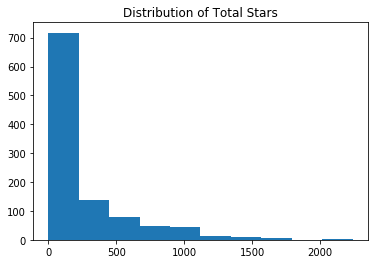

In [5]:
#add new feature to find total number of stars earned

df['total_stars'] = df['number_review'] * df['overall_review']

plt.title('Distribution of Total Stars')
plt.hist(df.total_stars);



In [6]:
#consider dropping number_amenities
#consider adding interaction values

# 1. Data Cleaning

In [7]:
#function that automates all the cleaning in previous version

def airbnb_clean(df):
    
    #Dropping Unneeded Columns for analysis
    df = df.drop(['link'], axis = 1) #dropping link column, not needed
    df = df.drop(['id'], axis = 1) #dropping id column, not needed
    
    #creating a mask to get rid of one-off listing types
    mask = ((df["listing_type"] != "Yurt") & (df["listing_type"] != "Lighthouse") & (df["listing_type"] != "Tiny")) & (df["listing_type"] != "Camper/RV")
    df = df[mask]
    
    return df


In [8]:
def dummy(df):    
    #create dummy variables for categorical data: listing_type, neighborhood, shared_bath and drop first
    df = pd.get_dummies(df, drop_first = True) #dropped categories will essentially be the baseline
    
    return df
    

### Removed Outliers in Price and Zero Reviews

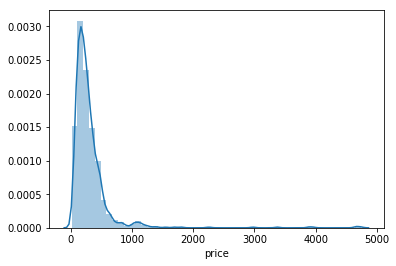

In [9]:
#Histogram on distribution of price
sns.distplot(df.price)

plt.savefig('pricedistoutliers.png')

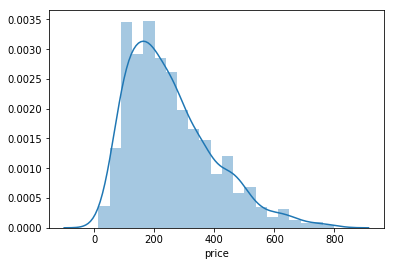

In [10]:
#Histogram removing prices above 800
sns.distplot(df.price[df['price'] <= 800])

plt.savefig('priceoutliersremoved.png')

In [11]:
#function that removes zero-review listings

def remove_zero_reviews(df):
    df_with_review = df[df.number_review != 0]
    
    return df_with_review

In [12]:
#function that removes price outliers that takes in the outlier bound

def remove_price_outliers(df,outlier):
    df = df[df.price <= outlier]
    
    return df

In [13]:
df.head()

,id,link,neighborhood,price,listing_type,num_guests,num_bed,num_bath,shared_bath,num_ammenities,number_review,overall_review,accuracy,communication,cleanliness,value,check_in,location,new_listing,total_stars
0,25841637,https://www.airbnb.com/rooms/25841637?location...,downtown,158,Private,4,1,1.0,sharedbath,5,86,4.5,4.7,4.7,4.8,4.8,4.8,4.6,No,387.0
1,24392338,https://www.airbnb.com/rooms/24392338?location...,downtown,225,Entire,4,2,1.0,notshared,4,109,4.5,4.8,4.9,4.7,4.8,4.8,4.9,No,490.5
2,25838923,https://www.airbnb.com/rooms/25838923?location...,downtown,130,Private,2,1,1.0,sharedbath,5,73,4.5,4.7,4.7,4.9,4.9,4.9,4.6,No,328.5
3,13971471,https://www.airbnb.com/rooms/13971471?location...,downtown,79,Shared,1,1,1.0,sharedbath,5,230,5.0,4.9,5.0,4.9,4.9,4.9,5.0,No,1150.0
4,34929016,https://www.airbnb.com/rooms/34929016?location...,downtown,86,Private,1,1,1.0,sharedbath,4,10,5.0,4.8,5.0,4.4,4.9,4.9,5.0,No,50.0


In [14]:
#apply cleaning function to df
df = airbnb_clean(df)


In [15]:
df.head()

,neighborhood,price,listing_type,num_guests,num_bed,num_bath,shared_bath,num_ammenities,number_review,overall_review,accuracy,communication,cleanliness,value,check_in,location,new_listing,total_stars
0,downtown,158,Private,4,1,1.0,sharedbath,5,86,4.5,4.7,4.7,4.8,4.8,4.8,4.6,No,387.0
1,downtown,225,Entire,4,2,1.0,notshared,4,109,4.5,4.8,4.9,4.7,4.8,4.8,4.9,No,490.5
2,downtown,130,Private,2,1,1.0,sharedbath,5,73,4.5,4.7,4.7,4.9,4.9,4.9,4.6,No,328.5
3,downtown,79,Shared,1,1,1.0,sharedbath,5,230,5.0,4.9,5.0,4.9,4.9,4.9,5.0,No,1150.0
4,downtown,86,Private,1,1,1.0,sharedbath,4,10,5.0,4.8,5.0,4.4,4.9,4.9,5.0,No,50.0


In [16]:
df = dummy(df)

In [17]:
#df= df.drop('num_ammenities',axis = 1)

#df.head()

In [18]:
df2 = df.copy() #make copy of new dataset
df2.head()

,price,num_guests,num_bed,num_bath,num_ammenities,number_review,overall_review,accuracy,communication,cleanliness,...,location,total_stars,neighborhood_downtown,neighborhood_midtown,neighborhood_uptown,listing_type_Private,listing_type_Room,listing_type_Shared,shared_bath_sharedbath,new_listing_Yes
0,158,4,1,1.0,5,86,4.5,4.7,4.7,4.8,...,4.6,387.0,1,0,0,1,0,0,1,0
1,225,4,2,1.0,4,109,4.5,4.8,4.9,4.7,...,4.9,490.5,1,0,0,0,0,0,0,0
2,130,2,1,1.0,5,73,4.5,4.7,4.7,4.9,...,4.6,328.5,1,0,0,1,0,0,1,0
3,79,1,1,1.0,5,230,5.0,4.9,5.0,4.9,...,5.0,1150.0,1,0,0,0,0,1,1,0
4,86,1,1,1.0,4,10,5.0,4.8,5.0,4.4,...,5.0,50.0,1,0,0,1,0,0,1,0


In [19]:
df2.isnull().sum()

price                     0
num_guests                0
num_bed                   0
num_bath                  0
num_ammenities            0
number_review             0
overall_review            0
accuracy                  0
communication             0
cleanliness               0
value                     0
check_in                  0
location                  0
total_stars               0
neighborhood_downtown     0
neighborhood_midtown      0
neighborhood_uptown       0
listing_type_Private      0
listing_type_Room         0
listing_type_Shared       0
shared_bath_sharedbath    0
new_listing_Yes           0
dtype: int64

In [20]:
df_eda[df_eda.listing_type == 'Private'].shared_bath.value_counts()

sharedbath    378
notshared     100
Name: shared_bath, dtype: int64

In [21]:
#removing outlier prices
df2 = remove_price_outliers(df2, 800) #Removing listings above 800 in price

print(df2.price.max(),df2['price'].count())

800 1010


In [22]:
#remove zero review listings
df2 = remove_zero_reviews(df2)

print(df2.number_review.min(),df2['price'].count())

3 780


In [23]:
#Preparing df_eda for eda analysis
df_eda = airbnb_clean(df_eda)
df_eda = remove_price_outliers(df_eda, 800)

df_eda = remove_zero_reviews(df_eda)

In [24]:
#generating newlisting col for df_eda

#add new column/feature to account for zero-review listings
df_eda['new_listing'] = np.where(df_eda['number_review'] < 10, 'Yes', 'No')

df_eda.new_listing.value_counts()

No     627
Yes    153
Name: new_listing, dtype: int64

In [25]:
df_eda.groupby('listing_type').price.mean()

listing_type
Entire     372.344961
Private    169.394608
Room       262.775862
Shared     115.357143
Name: price, dtype: float64

In [26]:
df_eda.groupby(['neighborhood', 'listing_type']).price.mean()

neighborhood  listing_type
centralpark   Entire          363.071429
              Private         205.838710
              Room            219.000000
              Shared          109.444444
downtown      Entire          396.244898
              Private         195.987805
              Room            279.000000
              Shared          145.333333
midtown       Entire          404.416667
              Private         171.000000
              Room            261.725490
              Shared          107.117647
uptown        Entire          305.500000
              Private         144.989305
              Shared          106.111111
Name: price, dtype: float64

# 2. EDA 

In [27]:
#df_reviews = remove_zero_reviews(df)

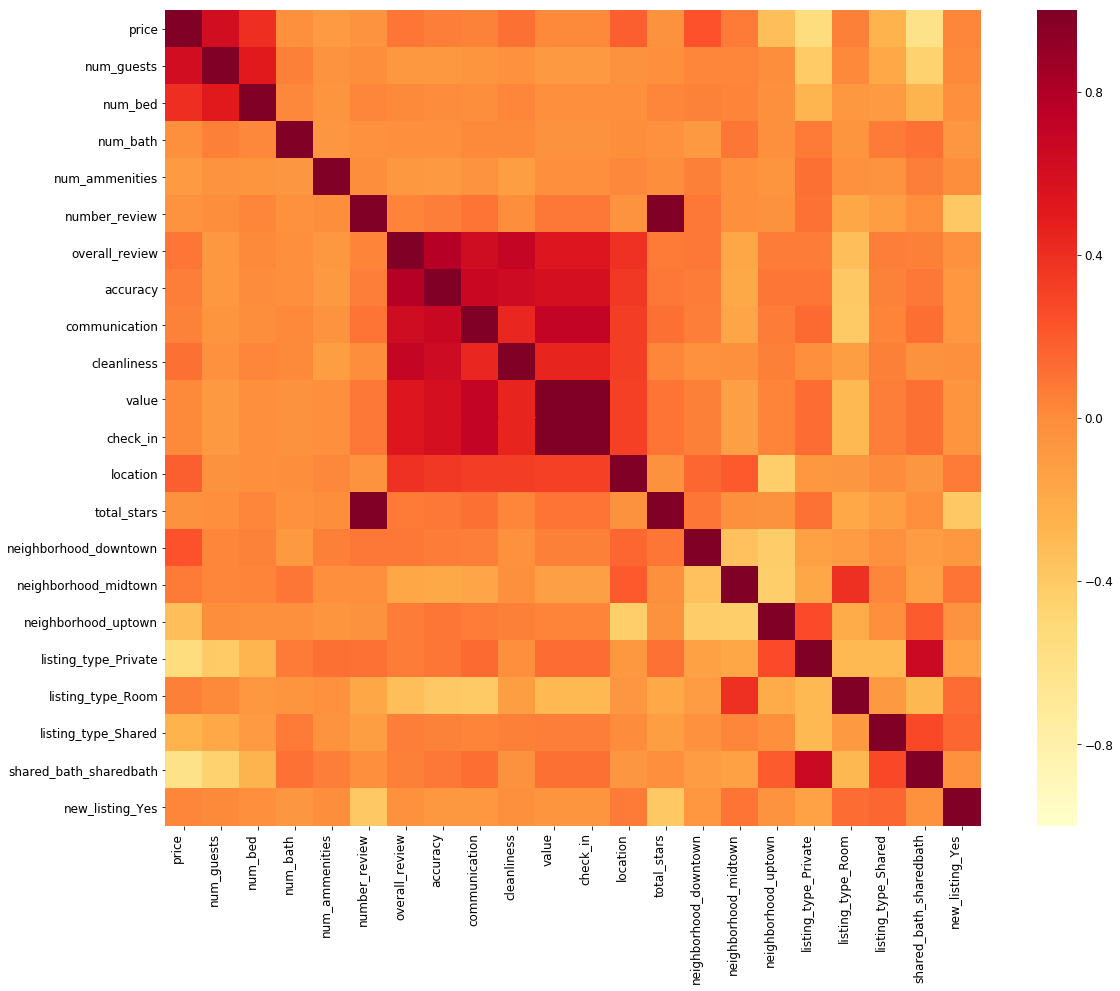

In [28]:
data = df2

plt.figure(figsize = (20,15) )

plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap='YlOrRd',
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

plt.savefig('Heatmap.png')

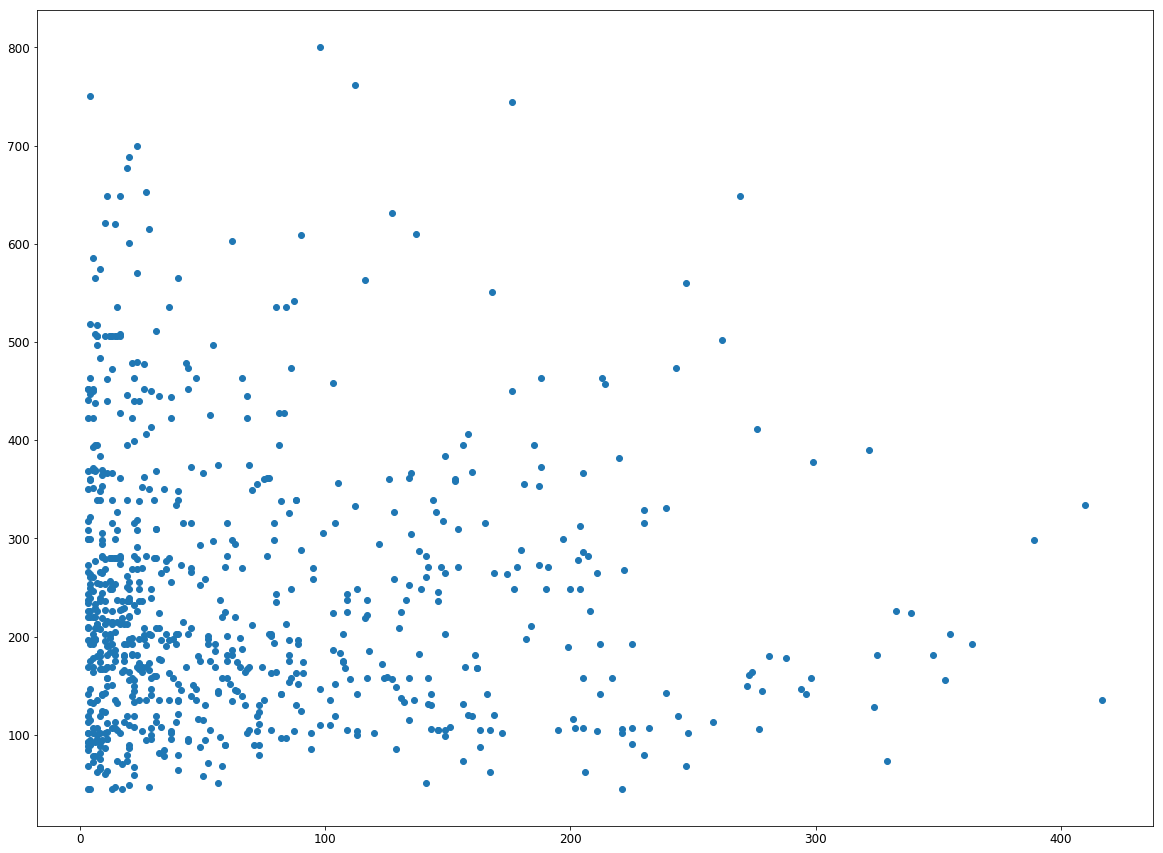

In [29]:
df2 = df2.sort_values(by = 'number_review')
plt.figure(figsize = (20,15))

x = df2.number_review
y = df2.price

plt.scatter(x,y)

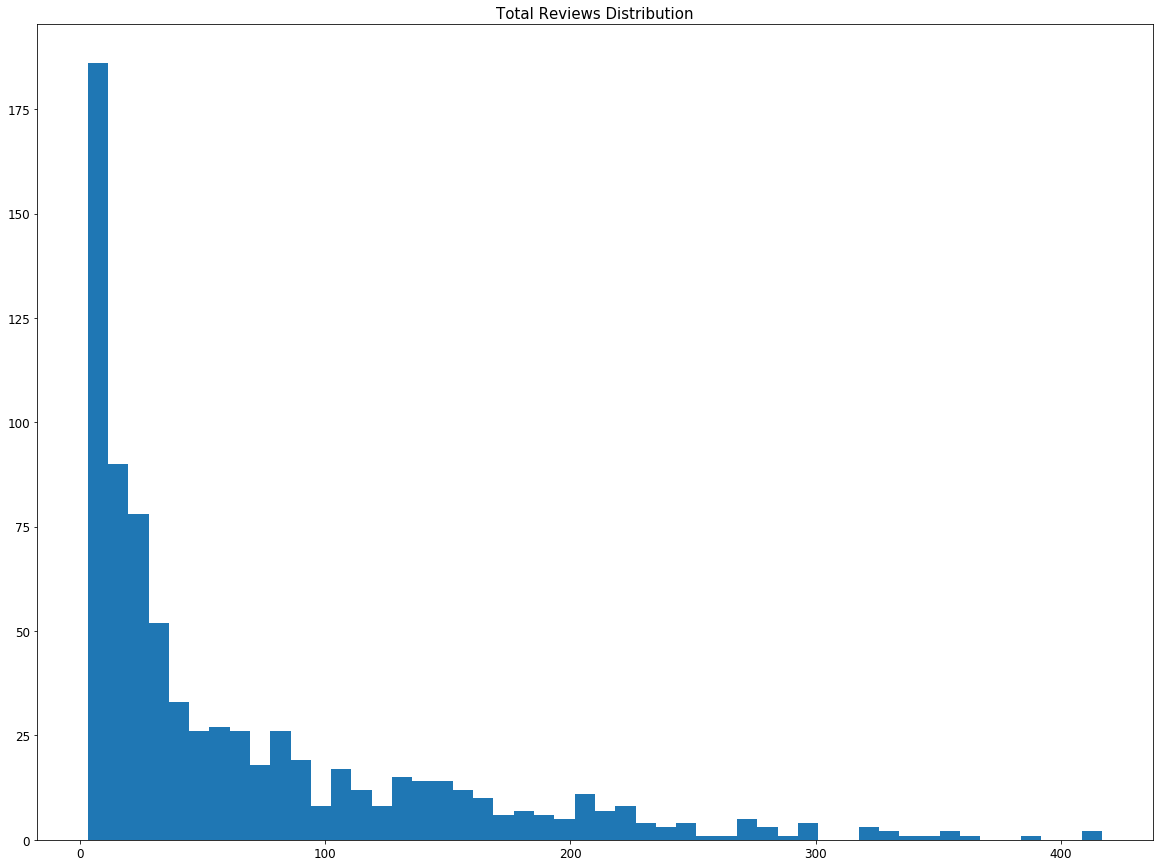

In [30]:
#Checking Distribution for Reviews
plt.figure(figsize = (20,15))
bins = 50
plt.title('Total Reviews Distribution', fontsize = 15)
plt.hist(df2.number_review, bins = bins);


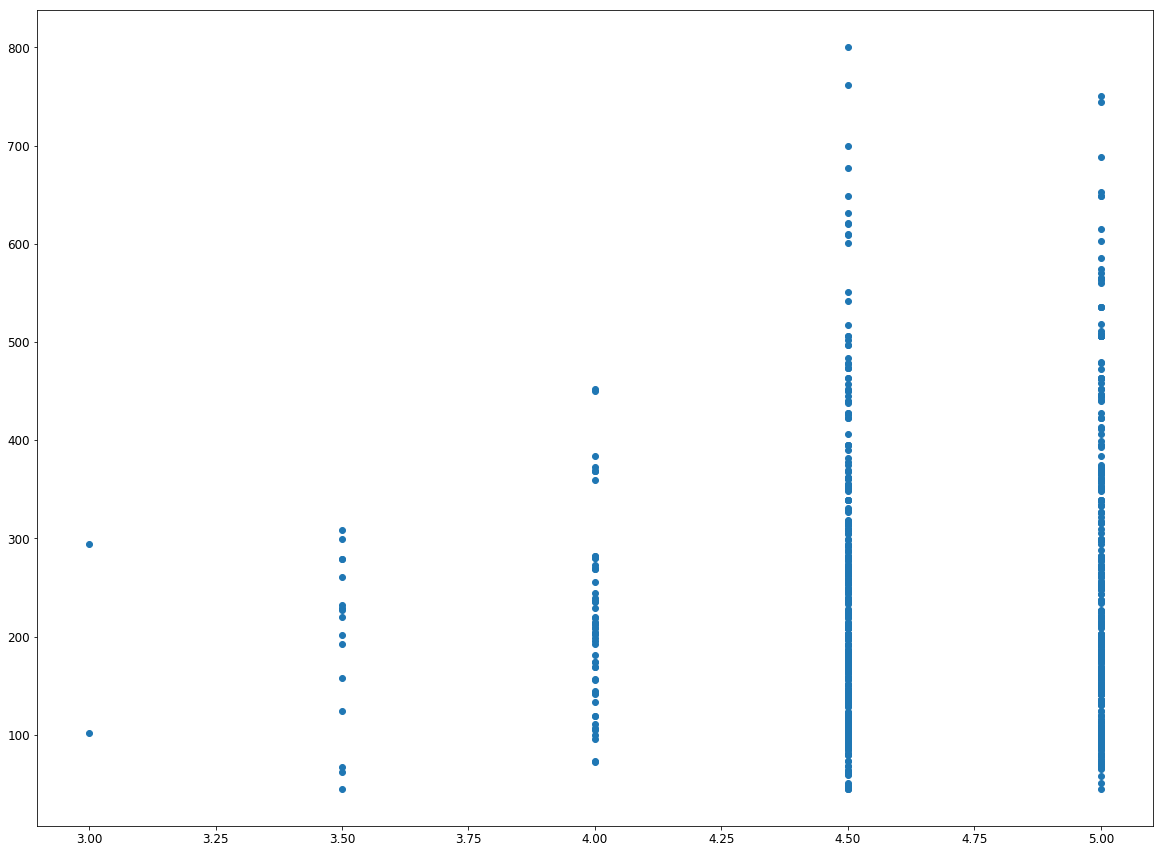

In [31]:
plt.figure(figsize = (20,15))
x = df2.overall_review
y = df2.price

plt.scatter(x,y)

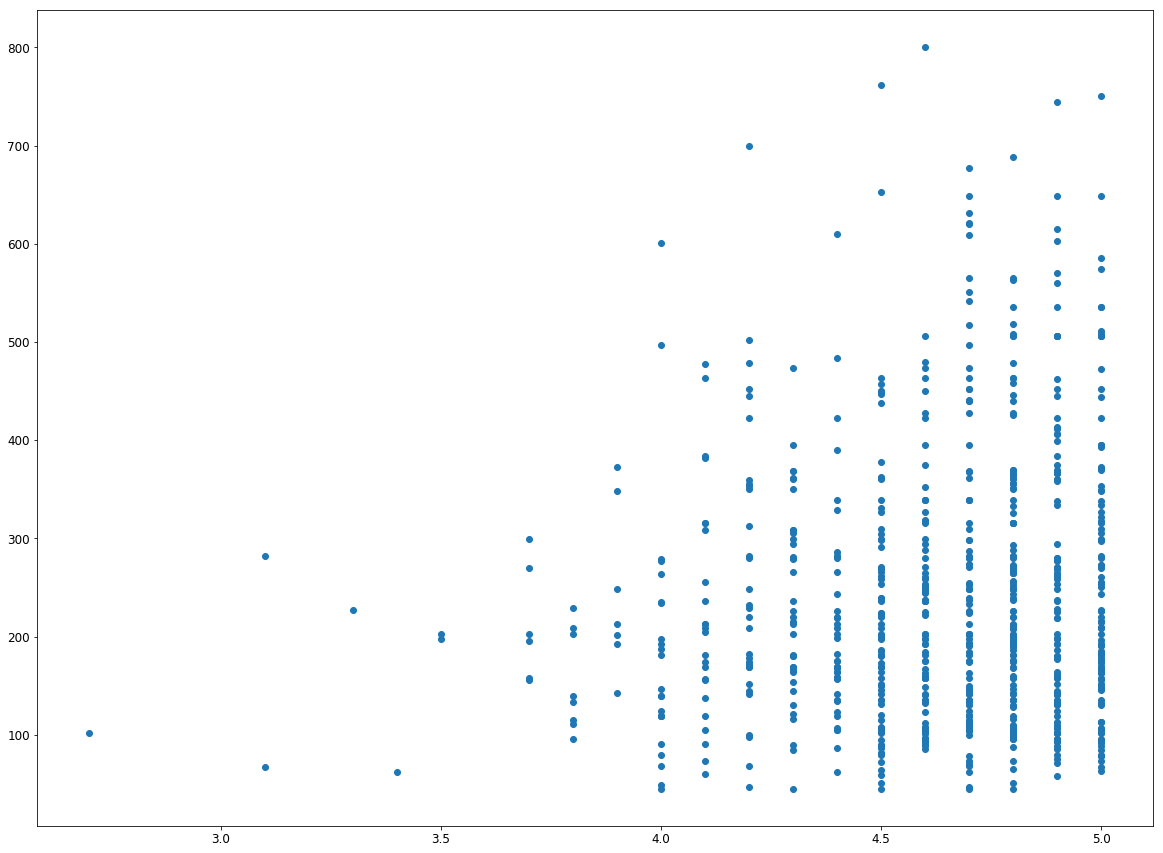

In [32]:
plt.figure(figsize = (20,15))
x = df2.cleanliness
y = df2.price

plt.scatter(x,y)

In [33]:
#pairplot

#sns.pairplot(df2)


### Potential Relationships Observed

num_guests, num_bed, num_bath: positive linear, possibly exponential for bath <br />
num_amenities: doesn't look very useful <br />
num_review: looks constant, may need to do some transformations such as total stars (num reviews * average review) <br />
neighborhood:Downtown is slightly positive, uptown negative, everything else slightly negative <br />
listing_type: Entire is pretty positive, shared is pretty negative, rest is slightly negative <br />
shared_bath: shared baths listings are very negative <br />

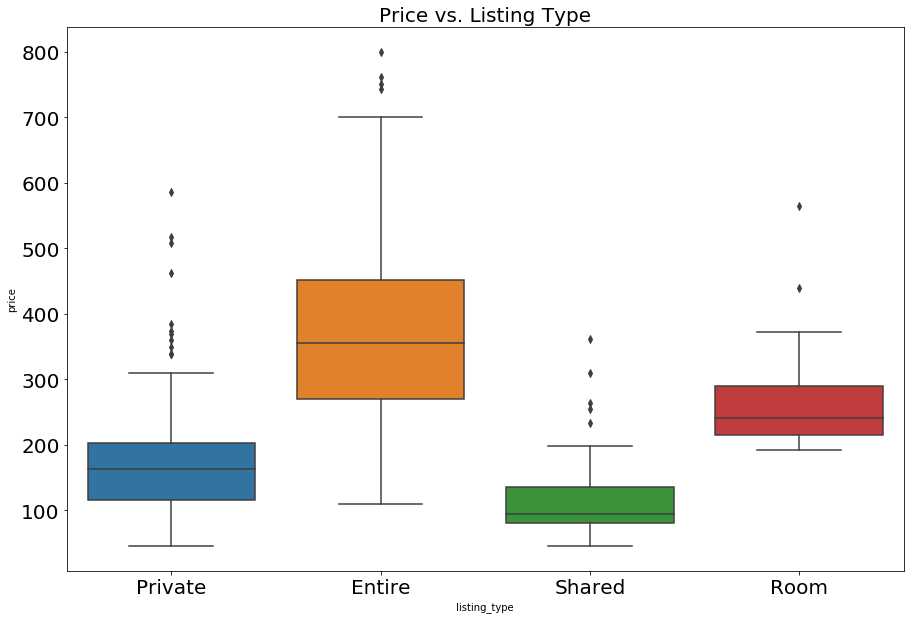

In [34]:
#Generate Boxplots for Analysis:
#Location, Listing_type, and Shared_Bed,
#df_eda = airbnb_clean(df_eda)

plt.figure(figsize = (15,10))

x = df_eda.listing_type
y = df_eda.price

plt.title('Price vs. Listing Type',fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
sns.boxplot(x,y);

plt.savefig('Listing_type_boxplot.png')

#Looks like Entire Space Listings have a noticeable higher price on average than other listing types

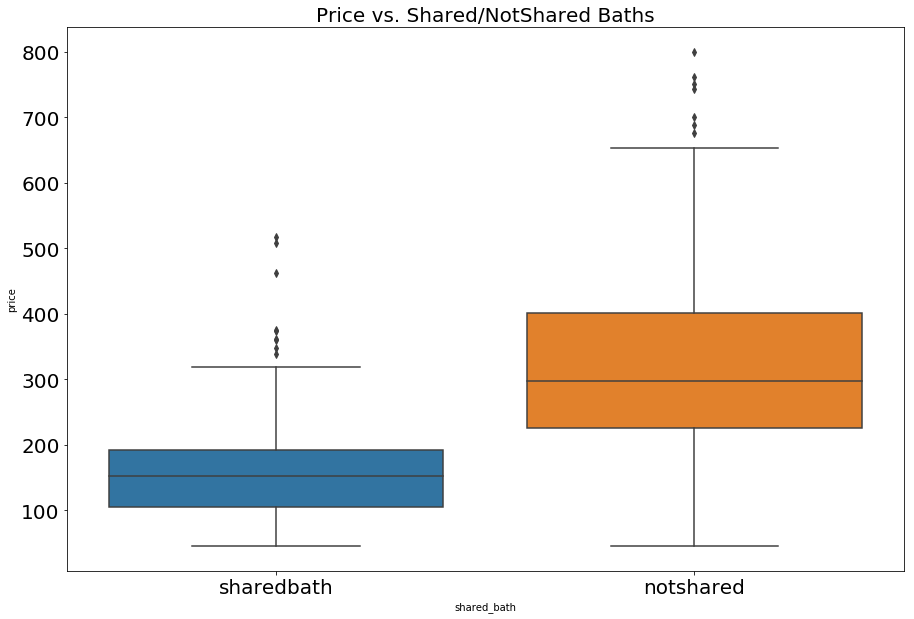

In [35]:
#listings with private bathrooms appear to be more expensive
plt.figure(figsize = (15,10))


plt.title('Price vs. Shared/NotShared Baths',fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
x = df_eda.shared_bath
y = df_eda.price

sns.boxplot(x,y);

plt.savefig('shared_bath_boxplot.png')

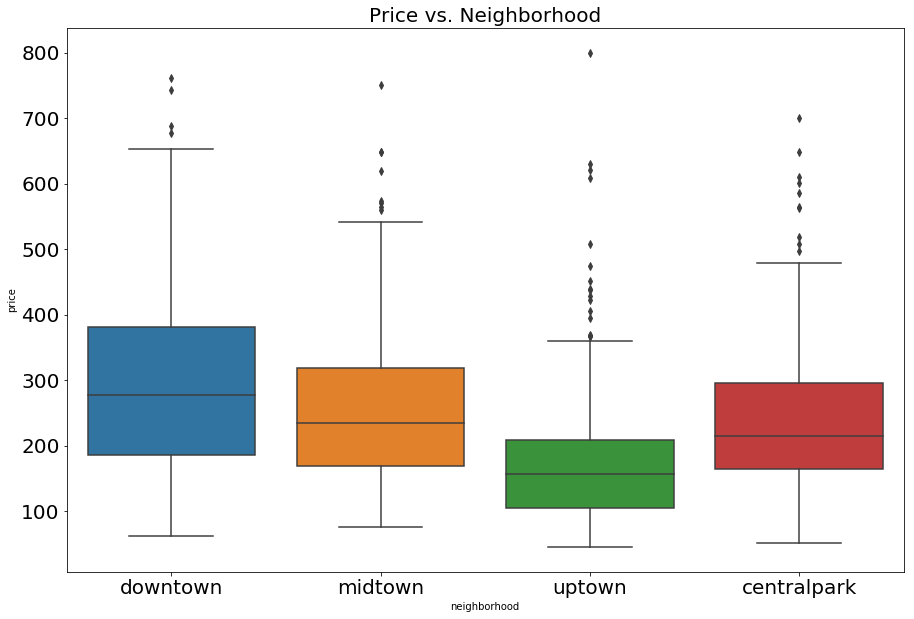

In [36]:
#listings located downtown seem to be slightly higher in price than listings elsewhere where
#listings updtown are noticeablely lower in price than elsewhere
plt.figure(figsize = (15,10))

x = df_eda.neighborhood
y = df_eda.price


plt.title('Price vs. Neighborhood',fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

sns.boxplot(x,y);

plt.savefig('neighborhood_boxplot.png')

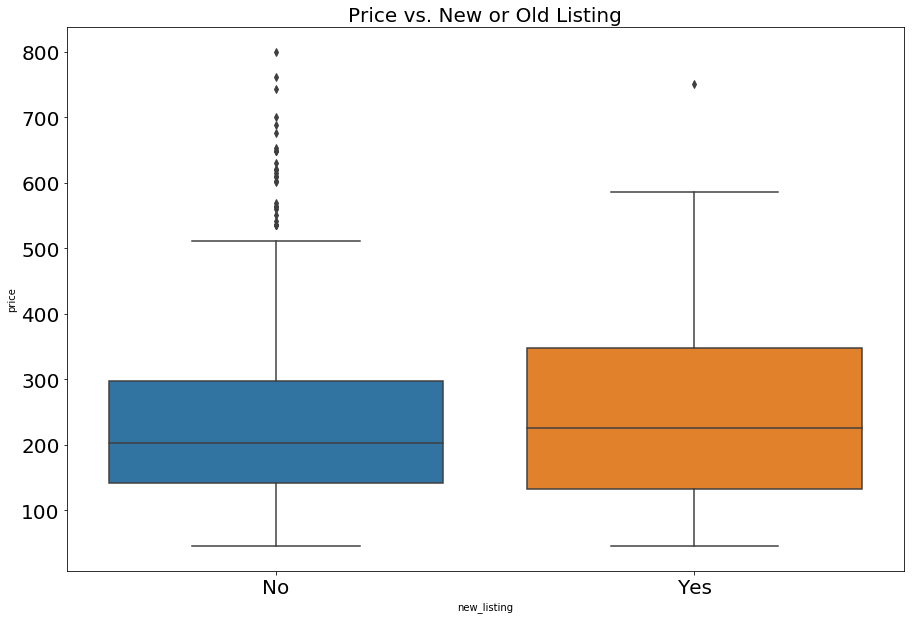

In [37]:
#New listings appear to be abit more expensive than older listings (15+ reviews)
plt.figure(figsize = (15,10))

x = df_eda.new_listing
y = df_eda.price


plt.title('Price vs. New or Old Listing',fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

sns.boxplot(x,y);

plt.savefig('new_old_listing_boxplot.png')

# 3. Splitting Test Data

In [38]:
#Seperates Target and Features
X, y = df2.drop('price',axis=1), df2['price']

#Hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state= 7) 

In [39]:
df2.head()
df2.describe()

,price,num_guests,num_bed,num_bath,num_ammenities,number_review,overall_review,accuracy,communication,cleanliness,...,location,total_stars,neighborhood_downtown,neighborhood_midtown,neighborhood_uptown,listing_type_Private,listing_type_Room,listing_type_Shared,shared_bath_sharedbath,new_listing_Yes
count,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,...,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000
mean,239.588462,2.738462,1.152564,1.089103,4.283333,67.702564,4.660256,4.709231,4.808462,4.619231,...,4.809359,316.464744,0.253846,0.262821,0.337179,0.523077,0.074359,0.071795,0.507692,0.196154
std,136.119807,1.504229,0.471042,0.381803,0.599939,77.519263,0.361795,0.286032,0.241317,0.329413,...,0.214080,363.532238,0.435490,0.440448,0.473050,0.499788,0.262523,0.258314,0.500262,0.397341
min,45.000000,1.000000,0.000000,0.000000,2.000000,3.000000,3.000000,3.300000,3.400000,2.700000,...,3.300000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,140.750000,2.000000,1.000000,1.000000,4.000000,12.000000,4.500000,4.600000,4.700000,4.500000,...,4.700000,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,203.000000,2.000000,1.000000,1.000000,4.000000,32.500000,4.500000,4.800000,4.900000,4.700000,...,4.900000,155.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,306.000000,4.000000,1.000000,1.000000,4.000000,98.000000,5.000000,4.900000,5.000000,4.900000,...,5.000000,464.625000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,800.000000,14.000000,6.000000,8.000000,6.000000,417.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,2085.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Note to Self:

df2 is df1 excluding the outliers and zero-review  <br >
df_eda contains original categorical data to generate certain vizualizations not possible with other frames

# 4. Base Model and Cross Validation

In [40]:
#creating a base linear regression model
lm = LinearRegression()
lm.fit(X, y)

print(f'Linear Regression val R^2: {lm.score(X, y)}') 
#score is on low end should do transformations to get model a better relationship
#0.46501800196570975 old value without new listings
#0.4652649200896588 new Value without new listings
#
#.68 with Total Stars

Linear Regression val R^2: 0.6701391237005973


In [41]:
#base linear regression model prediction
lm.score(X_test,y_test)

#0.4643197643320251
#0.648 with total stars and new_listing

0.6827954956585923

In [42]:
cross_val_score(lm, X, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2').mean()

#0.648 with total stars and new_listing
#0.65 without total stars and new_listing
#0.6482962340168467 with hotels removed

0.6368562511401245

In [43]:
list(zip(X.columns, lm.coef_))

[('num_guests', 30.374989519891642),
 ('num_bed', 28.15523271565076),
 ('num_bath', 1.7610887175039769),
 ('num_ammenities', -8.6072904075743),
 ('number_review', -0.8643099224234678),
 ('overall_review', 30.499838690041774),
 ('accuracy', -11.700683676769403),
 ('communication', 13.673545618211138),
 ('cleanliness', 27.701638352864972),
 ('value', 3.3462608587086846),
 ('check_in', 3.3462608587087015),
 ('location', -14.791913542302867),
 ('total_stars', 0.1579859228009643),
 ('neighborhood_downtown', 18.369716572772433),
 ('neighborhood_midtown', -10.154173173295165),
 ('neighborhood_uptown', -71.91135409781181),
 ('listing_type_Private', -88.3025809534286),
 ('listing_type_Room', -63.00474878116401),
 ('listing_type_Shared', -137.24241772910887),
 ('shared_bath_sharedbath', -37.24961448717582),
 ('new_listing_Yes', 0.2989289412235559)]

# 5. Different Models and Validation

In [44]:
#Second degree Polyreg
p = PolynomialFeatures(degree=2)
lm.fit(p.fit_transform(X),y)
lm.score(p.transform(X),y)

#Score is great 0.7804906689013609...lets CV

0.7880701342516361

In [45]:
lm.score(p.transform(X_test),y_test)

#Test Score is still good 0.5528900635469121

0.048492708403468865

In [46]:
cross_val_score(lm, p.transform(X), y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2').mean()

#r2 is all over the place, poly reg may not be a good predictor

0.018249606932149255

In [47]:
# Possible Direction logistic regression for classification rather than linear

In [48]:
#LassoCV
std = StandardScaler()
std.fit(X.values)

X_tr = std.transform(X.values)
X_te = std.transform(X_test.values)



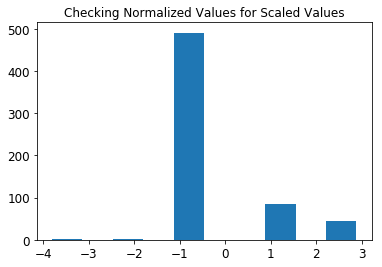

In [49]:
plt.title('Checking Normalized Values for Scaled Values')
plt.hist(X_tr[:,3]); #make sure I properly scaled these variables

In [50]:
alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y)

LassoCV(alphas=array([1.00000e-02, 1.04737e-02, ..., 9.54772e+01, 1.00000e+02]),
    copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=None, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [51]:
#Returns Optimal Alpha for test
lasso_model.alpha_

2.354286414322418

In [52]:
#The Coefficients of the Optimal Lasso Model
list(zip(X.columns, lasso_model.coef_))

[('num_guests', 45.841196487577946),
 ('num_bed', 11.92381808633254),
 ('num_bath', 0.0),
 ('num_ammenities', -3.188595199799954),
 ('number_review', -6.491906683323472),
 ('overall_review', 12.062419570778289),
 ('accuracy', 0.0),
 ('communication', 1.2153160896871724),
 ('cleanliness', 6.706929920032908),
 ('value', 0.0),
 ('check_in', 0.0),
 ('location', 0.0),
 ('total_stars', -0.0),
 ('neighborhood_downtown', 9.854366628872476),
 ('neighborhood_midtown', -0.15812178429539192),
 ('neighborhood_uptown', -28.368156017100308),
 ('listing_type_Private', -38.21069178510541),
 ('listing_type_Room', -12.612772065956863),
 ('listing_type_Shared', -30.114630854562),
 ('shared_bath_sharedbath', -20.67218278285781),
 ('new_listing_Yes', 0.0)]

In [53]:
#Lasso Score
test_set_pred = lasso_model.predict(X_te)
r2_score(y_test, test_set_pred)

#0.6762909752585203 with new_listing column
#0.7072747748398571 with both features, removing outliers and zero reviews

0.6800169773475317

In [54]:
mean_absolute_error(y_test, test_set_pred) #MAE

54.60220880171

In [55]:
lasso_model.intercept_

239.87500000000003

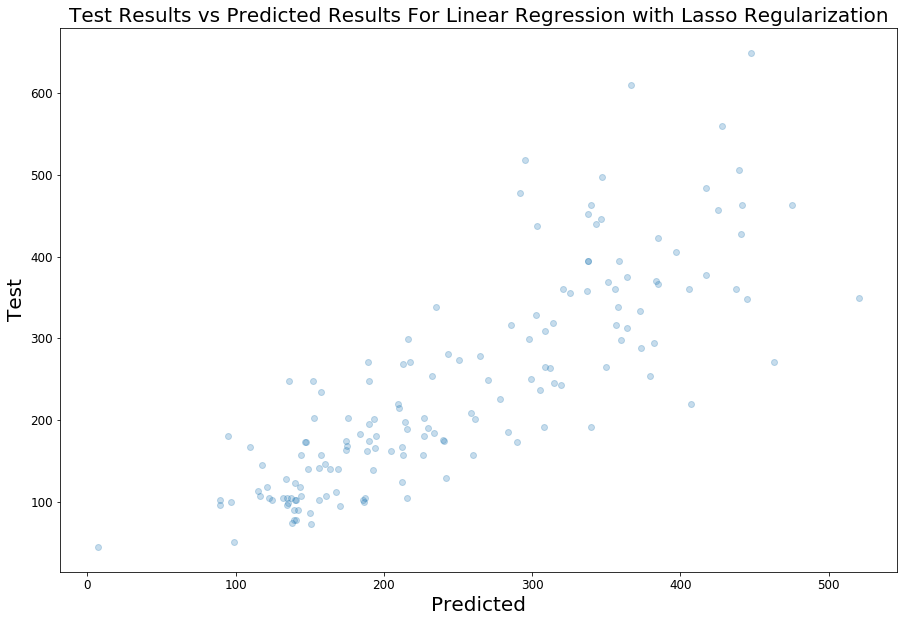

In [56]:
#Scatter Plot and Lasso
plt.figure(figsize = (15,10))
plt.scatter(test_set_pred, y_test, alpha=.25)

plt.title('Test Results vs Predicted Results For Linear Regression with Lasso Regularization', fontsize = 20)
plt.xlabel("Predicted",fontsize = 20)
plt.ylabel("Test",fontsize = 20)
#plt.plot(np.linspace(50,600,50), np.linspace(50,600,50)); #regression plot

plt.savefig('new_old_listing_boxplot.png')

In [57]:
#Ridge Model

alphavec = 10**np.linspace(-2,2,200)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_tr, y)

RidgeCV(alphas=array([1.00000e-02, 1.04737e-02, ..., 9.54772e+01, 1.00000e+02]),
    cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [58]:
ridge_model.alpha_

47.68611697714469

In [59]:
#Ridge Model Coefficients
list(zip(X.columns, ridge_model.coef_))


[('num_guests', 42.89273015554874),
 ('num_bed', 14.691276145593827),
 ('num_bath', 0.6851090489836332),
 ('num_ammenities', -5.1334633121599555),
 ('number_review', -5.909999665284134),
 ('overall_review', 10.819418934631052),
 ('accuracy', -1.0930698506386052),
 ('communication', 3.2794583874868115),
 ('cleanliness', 8.108428313096066),
 ('value', 0.5375307277159626),
 ('check_in', 0.5375307277159623),
 ('location', -0.7548202321173169),
 ('total_stars', -3.171263398310127),
 ('neighborhood_downtown', 10.772167456356168),
 ('neighborhood_midtown', -2.3919463095249105),
 ('neighborhood_uptown', -29.698043238338546),
 ('listing_type_Private', -35.65696945121688),
 ('listing_type_Room', -13.353434398767442),
 ('listing_type_Shared', -29.224755156046548),
 ('shared_bath_sharedbath', -23.810781906620047),
 ('new_listing_Yes', 0.12851469170937915)]

In [60]:
#Scoring the Ridge Model
test_set_pred = ridge_model.predict(X_te)
r2_score(y_test, test_set_pred)

#0.6656997462795555 with new_listing column
#0.7016982430770393 removing outliers, and zero reviews and adding in both new features

0.6709678067680426

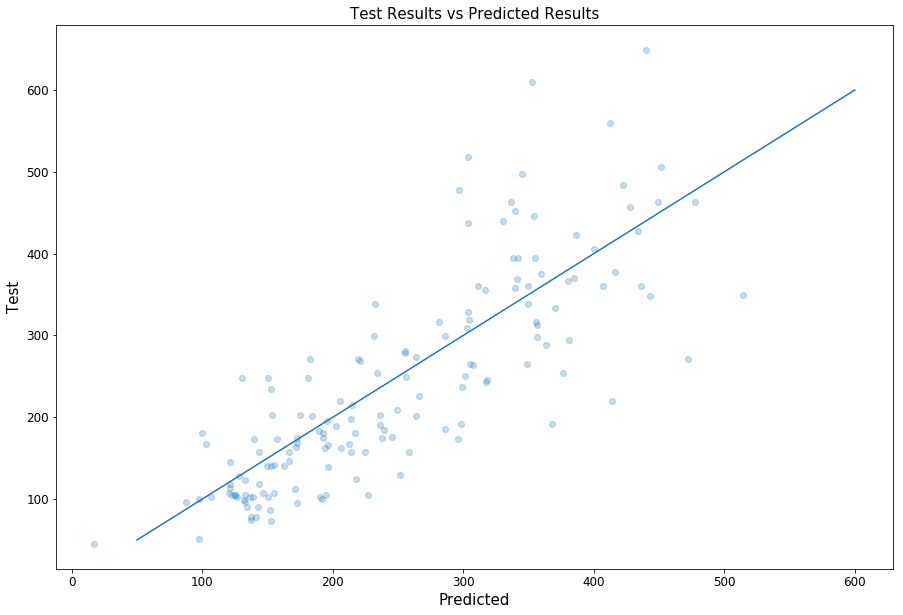

In [61]:
#Scatter Plot and Ridge
plt.figure(figsize = (15,10))
plt.scatter(test_set_pred, y_test, alpha=.25)

plt.title('Test Results vs Predicted Results', fontsize = 15)
plt.xlabel("Predicted",fontsize = 15)
plt.ylabel("Test",fontsize = 15)
plt.plot(np.linspace(50,600,50), np.linspace(50,600,50)); #regression plot


In [62]:
#Polyreg with Lasso Regularization
#Second degree Polyreg
p = PolynomialFeatures(degree=2)
lm.fit(p.fit_transform(X),y)
lm.score(p.transform(X),y)

#Score is great 0.7804906689013609...lets CV

0.7880701342516361

In [63]:
lm.score(p.transform(X_test),y_test)

#Test Score is still good 0.5528900635469121
#Like before, the score isn't very good, some regularization to zero out some feature coefficients may help

0.048492708403468865

In [64]:
#scaling poly terms

std = StandardScaler()
std.fit(p.fit_transform(X))


X_tr = std.transform(p.fit_transform(X))
X_te = std.transform(p.fit_transform(X_test))

In [65]:
alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

LassoCV(alphas=array([1.00000e-02, 1.04737e-02, ..., 9.54772e+01, 1.00000e+02]),
    copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=None, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [66]:
#Returns Optimal Alpha for test
lasso_model.alpha_

2.704959730463134

In [67]:
#The Coefficients of the Optimal Lasso Model
#Try to get Feature names

list(zip(p.get_feature_names(),lasso_model.coef_))

[('1', 0.0),
 ('x0', 0.0),
 ('x1', 0.0),
 ('x2', 0.0),
 ('x3', -0.0),
 ('x4', -0.0),
 ('x5', 0.0),
 ('x6', 0.0),
 ('x7', 0.0),
 ('x8', 0.0),
 ('x9', 0.0),
 ('x10', 0.0),
 ('x11', 0.0),
 ('x12', -0.0),
 ('x13', 0.0),
 ('x14', -0.0),
 ('x15', -0.0),
 ('x16', -0.0),
 ('x17', -0.0),
 ('x18', -0.0),
 ('x19', -0.0),
 ('x20', 0.0),
 ('x0^2', 0.0),
 ('x0 x1', 13.292131148108052),
 ('x0 x2', 15.470285457427625),
 ('x0 x3', 0.0),
 ('x0 x4', -0.0),
 ('x0 x5', 0.0),
 ('x0 x6', 0.0),
 ('x0 x7', 9.95548717451366),
 ('x0 x8', 20.710001861614963),
 ('x0 x9', 0.0),
 ('x0 x10', 0.0),
 ('x0 x11', 0.0),
 ('x0 x12', -0.0),
 ('x0 x13', 0.0),
 ('x0 x14', 2.5037756801880025),
 ('x0 x15', -8.511274139273159),
 ('x0 x16', -0.0),
 ('x0 x17', -0.0),
 ('x0 x18', -0.0),
 ('x0 x19', -5.292912888758743),
 ('x0 x20', 0.0),
 ('x1^2', 0.0),
 ('x1 x2', 9.783778998387053),
 ('x1 x3', 0.0),
 ('x1 x4', -4.812051775093647),
 ('x1 x5', 0.0),
 ('x1 x6', 0.0),
 ('x1 x7', 0.0),
 ('x1 x8', 0.0),
 ('x1 x9', 0.0),
 ('x1 x10', 0.0),

In [68]:
#Lasso Score with polyreg
test_set_pred = lasso_model.predict(X_te)
r2_score(y_test, test_set_pred)

#0.6762909752585203 with new_listing column
#0.7177735986217615 with new listing and total stars
#0.7154364397197761 with no additional features
#0.7177735986217615 with only new listing
#0.7178169919654773 with new listing and total stars
#0.642174781650235 removing hotel data

0.7024507706066243

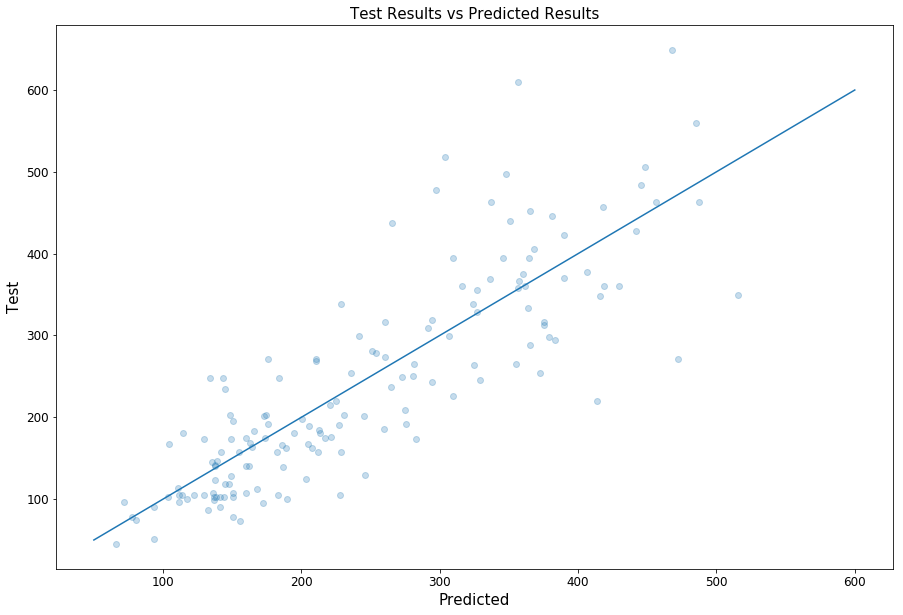

In [76]:
plt.figure(figsize = (15,10))
plt.scatter(test_set_pred, y_test, alpha=.25)

plt.title('Test Results vs Predicted Results', fontsize = 15)
plt.xlabel("Predicted",fontsize = 15)
plt.ylabel("Test",fontsize = 15)
plt.plot(np.linspace(50,600,50), np.linspace(50,600,50));

In [70]:
#Polyreg with Ridge Regularization

alphavec = 10**np.linspace(-2,2,200)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_tr, y)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RidgeCV(alphas=array([1.00000e-02, 1.04737e-02, ..., 9.54772e+01, 1.00000e+02]),
    cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [71]:
ridge_model.alpha_

100.0

In [72]:
list(zip(p.get_feature_names(),ridge_model.coef_))

[('1', 0.0),
 ('x0', 2.5110369139110844),
 ('x1', 0.331259800363908),
 ('x2', 0.14283824742526766),
 ('x3', -0.24899896829154491),
 ('x4', -1.6585176218155626),
 ('x5', 1.5016148664408266),
 ('x6', -0.9680852998115616),
 ('x7', 0.3692456161932006),
 ('x8', 0.8671554417791542),
 ('x9', -0.6591194982423271),
 ('x10', -0.6591194982423252),
 ('x11', -2.0567924070055446),
 ('x12', -0.5859379920591665),
 ('x13', 2.7899534802021577),
 ('x14', -1.6723926181660869),
 ('x15', -3.3898669446417773),
 ('x16', -1.8122078619919322),
 ('x17', -1.9201190925845075),
 ('x18', -2.4321471701856203),
 ('x19', -0.14866393696596755),
 ('x20', -0.2641130237513337),
 ('x0^2', 6.4815521763601405),
 ('x0 x1', 6.353078924013294),
 ('x0 x2', 10.498740684658088),
 ('x0 x3', 3.7425983917942656),
 ('x0 x4', 1.6481899062561396),
 ('x0 x5', 3.1178321653612984),
 ('x0 x6', 2.61649182017508),
 ('x0 x7', 4.061832660273243),
 ('x0 x8', 3.8610356541342483),
 ('x0 x9', 3.247998644036785),
 ('x0 x10', 3.2479986440367923),
 ('x

In [73]:
#Ridge Score with polyreg
test_set_pred = ridge_model.predict(X_te)
r2_score(y_test, test_set_pred)

#0.7177735986217615 with new listing and total stars
#0.6981382096756857 with no additional features
#0.7006449382566855 with only newlisting
#0.7029181808761543 new_listing and total stars
#0.6670923552817241 removing hotel data

0.7105858471203182

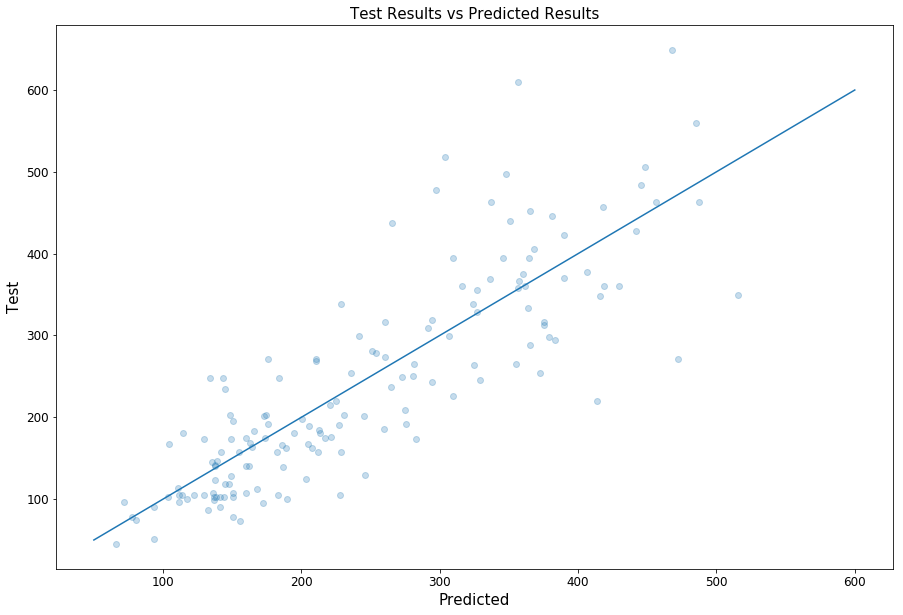

In [74]:
#Scatter Plot and Ridge
plt.figure(figsize = (15,10))
plt.scatter(test_set_pred, y_test, alpha=.25)

plt.title('Test Results vs Predicted Results', fontsize = 15)
plt.xlabel("Predicted",fontsize = 15)
plt.ylabel("Test",fontsize = 15)
plt.plot(np.linspace(50,600,50), np.linspace(50,600,50));